In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
from datetime import timedelta, datetime

import numpy as np
import yfinance as yf

from optfolio.optimize import Optimizer

In [70]:
PERIOD = '10y'
TICKERS = [
    # Internet services
    'msft',
    'goog',
    'fb',
#     'twtr',
    'vmw',
#     'orcl',
#     'bidu',
    'spot',
    # Application software
    'shop',
    'adbe',
    'crm',
#     'wday',
#     'sap',
    'sq',
    'team',
    # Comm. equipment
#     'csco',
    # Semiconductors
    'intc',
    'amd',
    'txn',
# #     'qcom',
    'nvda',
    # Misc
#     'dell',
    # Personal finance
    'v',
    'ma',
    'pypl',
    # Consumer directionary
    'aapl',
    'nke',
#     'ads',
#     'sne',
    'amzn',
#     'ebay',
#     'baba',
    # Aerospace
    'lmt',
    'noc',
#     'ba',
    # Media
    'nflx',
    'dis',
    # Airlines
    'dal',
    'ual',
#     'luv',
    # Automotive
    'tsla'
]

data = yf.download(
    tickers=TICKERS,
    period=PERIOD,
    interval='1d',
    auto_adjust=True,
    prepost=False,
    groupby='ticker'
).dropna(axis=1, how='all')

daily_returns = (data['Close'] / data['Close'].shift(1) - 1)[1:]
daily_returns.head()

[*********************100%***********************]  27 of 27 downloaded


,AAPL,ADBE,AMD,AMZN,CRM,DAL,DIS,FB,GOOG,INTC,...,PYPL,SHOP,SPOT,SQ,TEAM,TSLA,TXN,UAL,V,VMW
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-29,-0.036334,-0.017939,-0.053299,-0.004919,-0.009352,-0.032714,0.007042,NaN,-0.008153,-0.025992,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.023915,-0.031671,-0.007634,-0.019496
2010-02-01,0.013825,0.005573,0.069705,-0.052149,0.025802,0.032907,-0.001166,NaN,0.005796,0.010534,...,NaN,NaN,NaN,NaN,NaN,NaN,0.024501,0.042518,0.020118,0.003712
2010-02-02,0.006198,0.015394,-0.008772,-0.006309,-0.002454,0.021239,0.015558,NaN,-0.003540,0.015288,...,NaN,NaN,NaN,NaN,NaN,NaN,0.011123,0.076078,0.004060,0.001321
2010-02-03,0.016838,0.000000,-0.012642,0.008297,0.009225,-0.037262,0.025661,NaN,0.018256,-0.003422,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.004400,-0.026239,-0.005777,0.014244
2010-02-04,-0.035945,-0.022438,-0.079385,-0.026532,-0.048751,-0.077408,-0.035101,NaN,-0.025947,-0.033654,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.026519,-0.074850,-0.005811,-0.049155


## Stocks

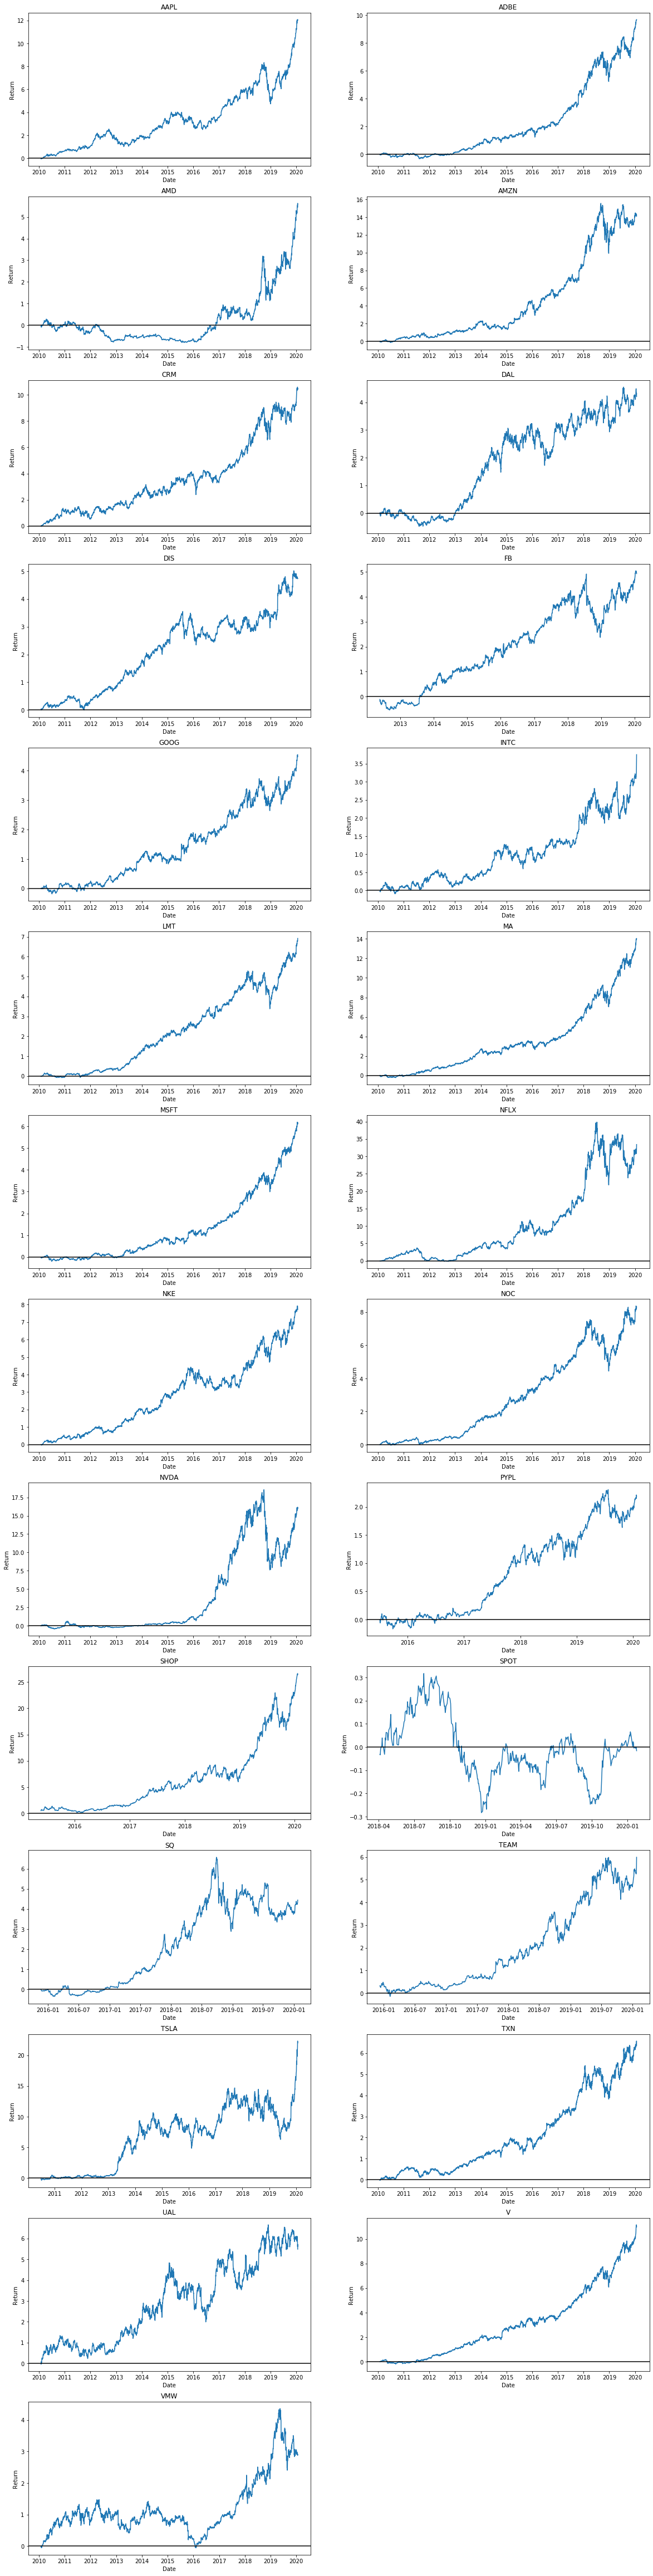

In [71]:
n_rows = int(np.ceil(daily_returns.shape[1] / 2.0))
plt.figure(figsize=(20, n_rows * 6))
for i, ticker in enumerate(daily_returns.columns):
    plt.subplot(n_rows, 2, i + 1)
    plt.title(ticker)
    plt.plot(np.cumprod(daily_returns[ticker] + 1) - 1)
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.axhline(0, color='black')
plt.show()

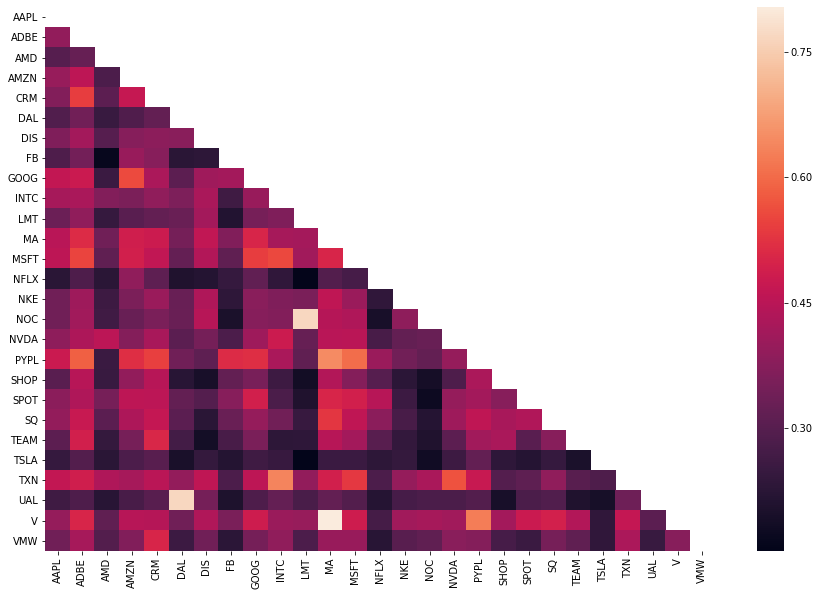

In [72]:
import seaborn as sns

plt.figure(figsize=(15,10))
cm = daily_returns.corr()
mask = (1 - np.tril(np.ones_like(cm))) == 1
cm[np.eye(cm.shape[0]) == 1] = np.nan
cm[mask] = np.nan
# cm[cm <= 0.5] = np.nan
sns.heatmap(cm)
plt.show()

In [73]:
spy_data = yf.download(tickers='SPY', period=PERIOD, interval='1d', auto_adjust=True, prepost=False)
spy_daily_returns = (spy_data['Close'] / spy_data['Close'].shift(1) - 1)[1:]
spy_daily_returns.head()

[*********************100%***********************]  1 of 1 downloaded


Date
2010-01-29   -0.010800
2010-02-01    0.015467
2010-02-02    0.012095
2010-02-03   -0.004980
2010-02-04   -0.030805
Name: Close, dtype: float64

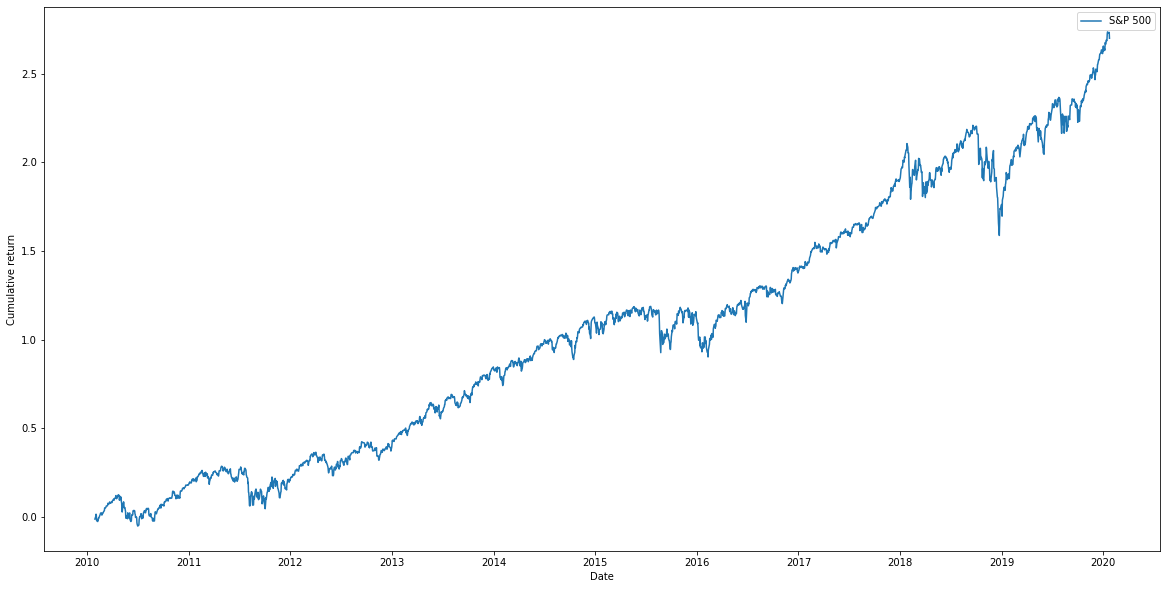

In [74]:
plt.figure(figsize=(20, 10))
plt.plot(np.cumprod(spy_daily_returns + 1) - 1, label='S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.show()

## Optimization

In [75]:
YEAR_BARS = 252
TEST_YEARS = 0
TRAIN_END_DATE = data.index.max() - timedelta(days=TEST_YEARS * 365)
train = daily_returns[(daily_returns.index < TRAIN_END_DATE)].fillna(0)
test = daily_returns[(daily_returns.index >= TRAIN_END_DATE)].fillna(0)

spy_train = spy_daily_returns[(spy_daily_returns.index < TRAIN_END_DATE)].fillna(0)
spy_test = spy_daily_returns[(spy_daily_returns.index >= TRAIN_END_DATE)].fillna(0)

print(np.any(np.isnan(train)))
print(train.shape)
train.tail()

False
(2514, 27)


,AAPL,ADBE,AMD,AMZN,CRM,DAL,DIS,FB,GOOG,INTC,...,PYPL,SHOP,SPOT,SQ,TEAM,TSLA,TXN,UAL,V,VMW
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-16,0.012526,0.007115,0.025129,0.008550,0.009003,0.004219,0.005543,0.002804,0.008685,0.012216,...,0.004789,0.006221,-0.004001,-0.011939,-0.001408,-0.009662,0.007664,0.014158,0.005756,0.017108
2020-01-17,0.011071,0.012624,0.023307,-0.007040,-0.002518,0.002424,-0.005444,0.001668,0.019763,-0.001006,...,0.005546,0.007933,-0.023051,-0.002014,-0.013881,-0.005823,0.011832,0.001787,0.018661,-0.005519
2020-01-21,-0.006777,0.000743,0.002356,0.014630,0.016682,-0.027245,-0.005335,-0.003151,0.002709,0.015940,...,0.000948,0.023215,0.004112,-0.015422,-0.011517,0.071890,-0.006378,-0.043590,0.012653,-0.017706
2020-01-22,0.003570,0.000171,0.007444,-0.002400,-0.013602,-0.011601,0.003135,-0.000542,0.001044,0.036003,...,-0.005596,-0.001461,-0.005572,0.005563,0.001066,0.040863,0.018952,-0.028558,0.002943,0.008609
2020-01-23,0.004816,0.004856,0.005444,-0.001526,0.006731,0.010563,0.000000,-0.007049,0.000471,0.009405,...,0.020693,0.009661,0.005739,0.008735,0.008976,0.004635,0.006825,0.018479,-0.006638,0.000000


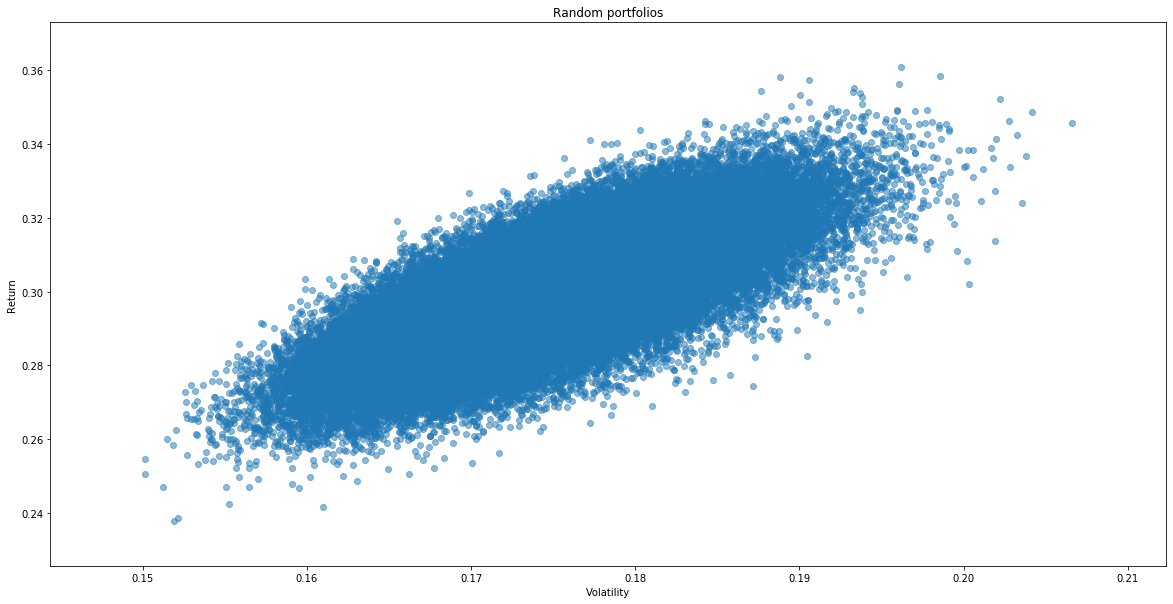

In [76]:
def random_population(n_assets, population_size):
    weights = np.random.uniform(0, 1, size=(population_size, n_assets))

    return weights / weights.sum(axis=-1).reshape((-1, 1))

def annualized_portfolio_return(returns, weights):
    weighted_returns = np.matmul(weights, np.mean(returns.values, 0))

    return (weighted_returns + 1) ** YEAR_BARS - 1


def annualized_portfolio_volatility(returns, weights):
    variance = np.sum(weights * np.matmul(weights, np.cov(returns.T.values)), -1)

    return np.sqrt(variance) * np.sqrt(YEAR_BARS)
    

def annualized_portfolio_performance(returns, weights):
    return np.stack([
        annualized_portfolio_return(returns, weights),
        annualized_portfolio_volatility(returns, weights)
    ], -1)

rand_weights = random_population(train.shape[1], 100000)
rand_solutions = annualized_portfolio_performance(train, rand_weights)

plt.figure(figsize=(20,10))
plt.title('Random portfolios')
plt.scatter(rand_solutions[:,1], rand_solutions[:,0], alpha=.5)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [78]:
optimizer = Optimizer(mutation_sigma=1.0, verbose=False, max_iter=250, population_size=5000)
solutions, stats = optimizer.run(train.values)

In [79]:
solutions.shape

(713, 27)

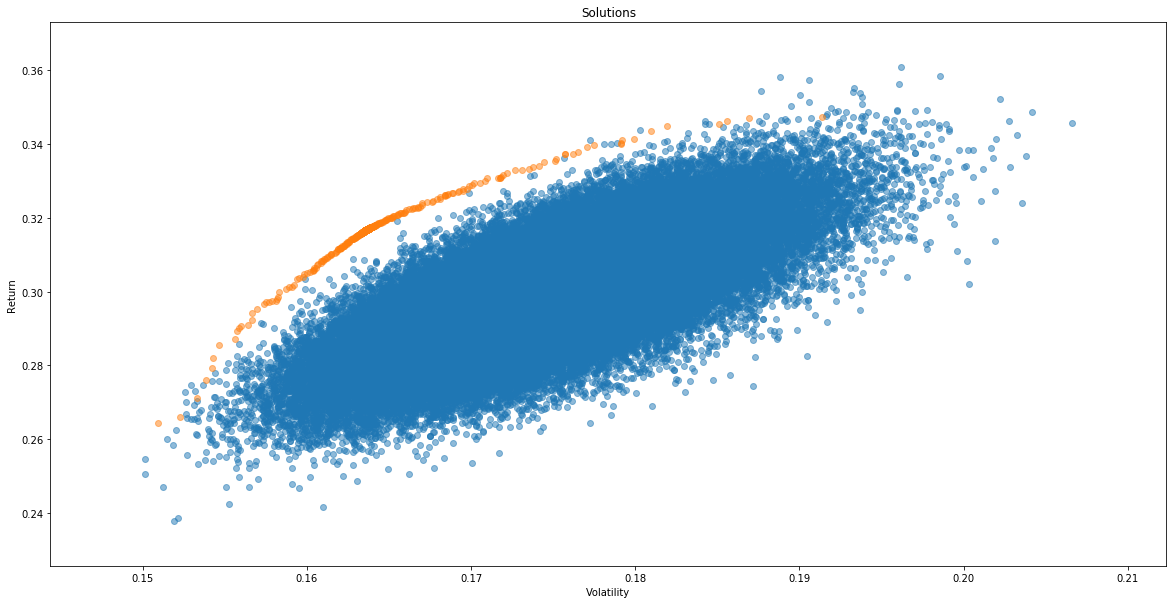

In [80]:
def plot_solutions(data, solutions, rand_solutions):
    ov = annualized_portfolio_performance(data, solutions)
    plt.figure(figsize=(20,10))
    plt.title('Solutions')
    plt.scatter(rand_solutions[:,1], rand_solutions[:,0], alpha=.5)
    plt.scatter(ov[:,1], ov[:,0], alpha=.5)
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.show()
    
plot_solutions(train, solutions, rand_solutions)

In [117]:
ov = annualized_portfolio_performance(train, solutions)
sharpe = ov[:,0] / ov[:,1]
# solution = solutions[np.argmin(np.abs(ov[:,1] - 0.16))]
solution = solutions[np.argmax(ov[:,0] / ov[:,1])]
annualized_portfolio_performance(train, solution)

array([0.32390557, 0.16700895])

In [128]:
CAPITAL = 38000

def print_allocation(data, allocations, prices):
    for ticker_id in np.argsort(-allocations):
        print('%s - %.4f, $%.2f USD, %.2f shares' % (data.columns[ticker_id], allocations[ticker_id] * 100, CAPITAL * allocations[ticker_id], (CAPITAL * allocations[ticker_id]) / prices[data.columns[ticker_id]]))
        
print_allocation(train, solution, data['Close'].iloc[-1])

SHOP - 6.8975, $2621.07 USD, 5.63 shares
NFLX - 6.8896, $2618.04 USD, 7.41 shares
LMT - 6.6571, $2529.71 USD, 5.85 shares
AAPL - 6.2140, $2361.32 USD, 7.42 shares
V - 5.9283, $2252.76 USD, 10.99 shares
NOC - 5.8205, $2211.80 USD, 5.80 shares
TEAM - 5.4689, $2078.17 USD, 14.16 shares
TSLA - 5.1714, $1965.12 USD, 3.48 shares
NKE - 4.7804, $1816.54 USD, 17.80 shares
FB - 4.7545, $1806.69 USD, 8.29 shares
MA - 4.2375, $1610.26 USD, 4.98 shares
SQ - 4.1332, $1570.63 USD, 22.08 shares
DIS - 3.9015, $1482.57 USD, nan shares
AMZN - 3.4954, $1328.24 USD, 0.71 shares
UAL - 3.1204, $1185.76 USD, 14.48 shares
MSFT - 2.9362, $1115.74 USD, 6.76 shares
SPOT - 2.2608, $859.12 USD, 5.86 shares
PYPL - 2.2242, $845.19 USD, 7.23 shares
NVDA - 2.1641, $822.36 USD, 3.28 shares
ADBE - 2.1515, $817.55 USD, 2.33 shares
DAL - 1.9662, $747.15 USD, 12.70 shares
INTC - 1.7166, $652.29 USD, 9.53 shares
TXN - 1.6402, $623.28 USD, 4.78 shares
CRM - 1.4980, $569.24 USD, 3.13 shares
VMW - 1.4224, $540.52 USD, 3.59 shar

In [120]:
','.join(train.columns)

'AAPL,ADBE,AMD,AMZN,CRM,DAL,DIS,FB,GOOG,INTC,LMT,MA,MSFT,NFLX,NKE,NOC,NVDA,PYPL,SHOP,SPOT,SQ,TEAM,TSLA,TXN,UAL,V,VMW'

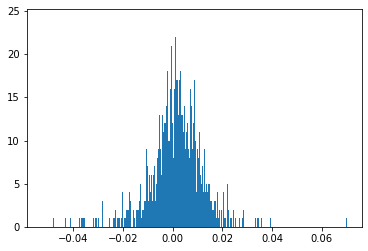

In [110]:
ret = np.dot(train, solution)
plt.hist(ret, bins=1000)
plt.show()

In [111]:
from optfolio.returns_projection import cumulative_n_period_returns, sample_returns, mcmc_sample_returns
from optfolio.report import plot_traces, returns_table

### S&P 500 MC Projection

In [112]:
print("Annualized return: %.6f" % (np.mean(spy_train + 1) ** 252 - 1))
print("Annualized volatility: %.6f" % (np.sqrt(np.var(spy_train) * 252)))

Annualized return: 0.153500
Annualized volatility: 0.146463


In [113]:
spy_traces = sample_returns(spy_train, 10 * 252, n_traces=100000)

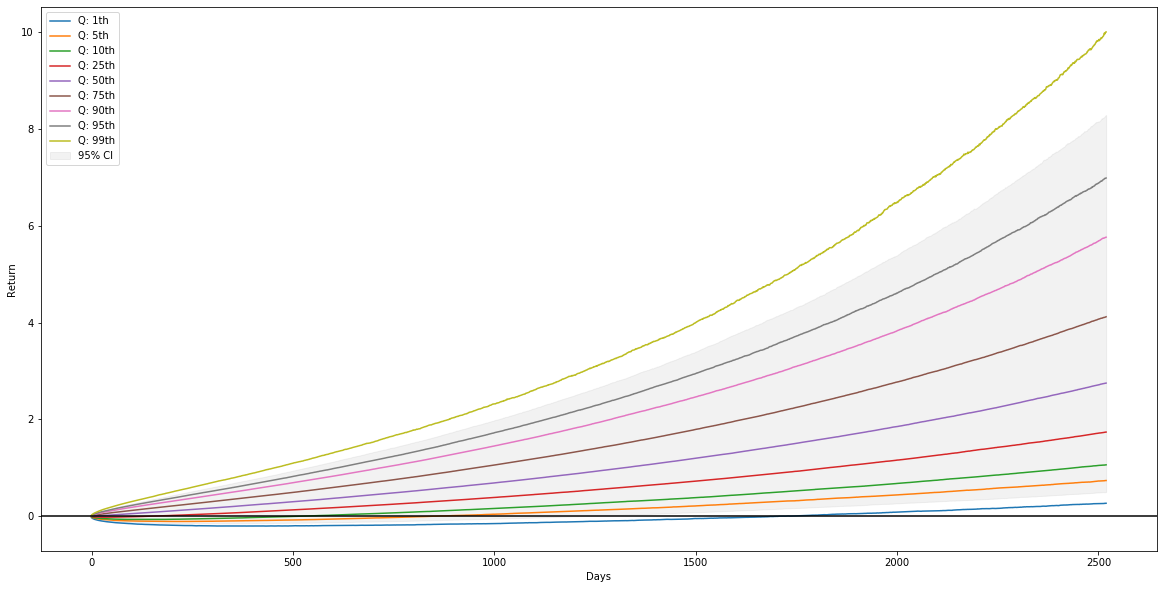

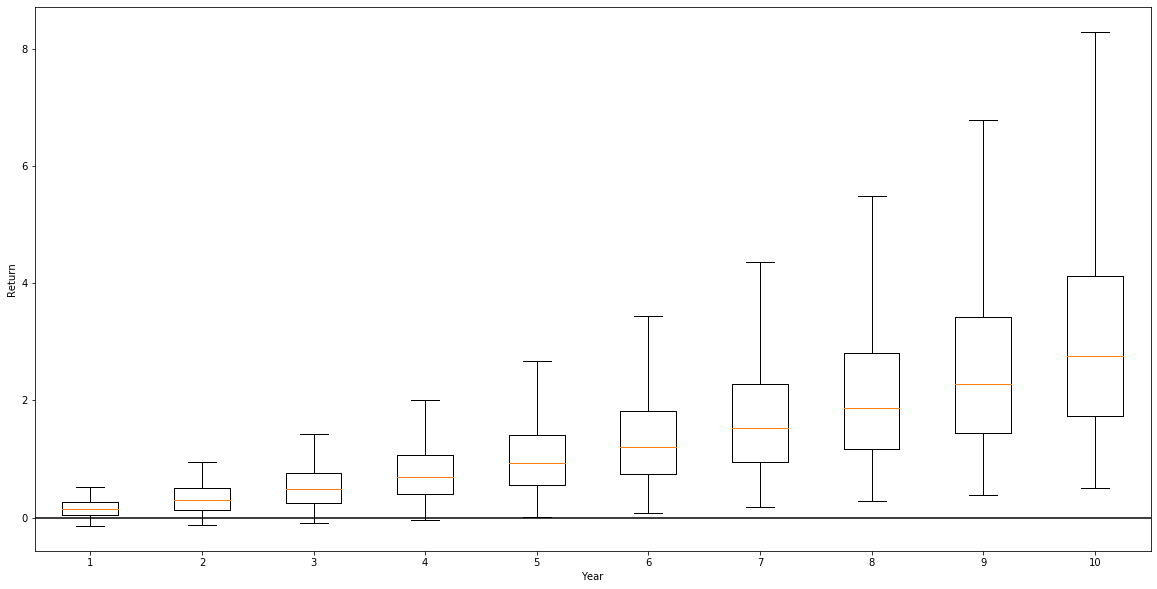

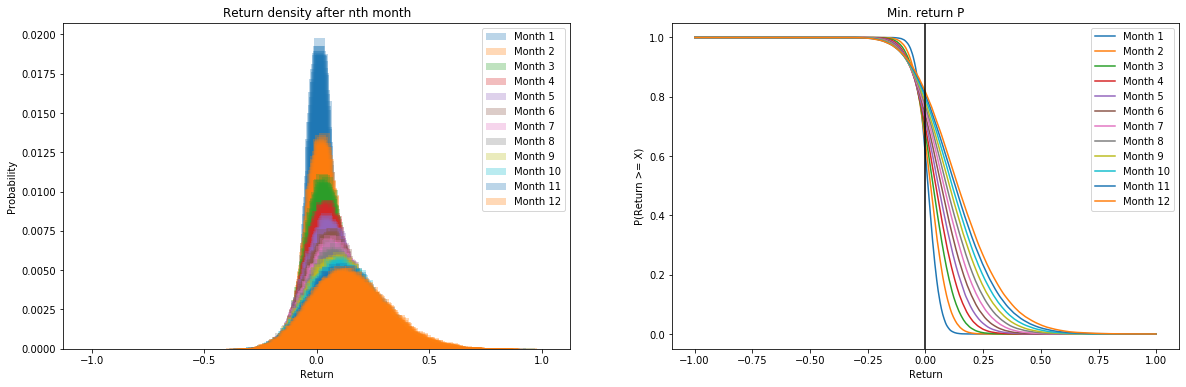

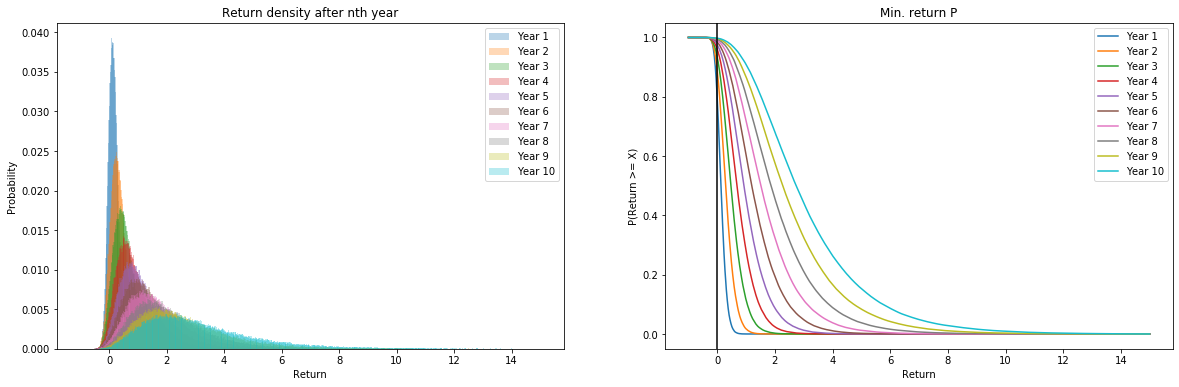

,< 0,> 0,>= 1,>= 2,>= 3,>= 4,>= 5,>= 6,>= 7,>= 8,>= 9,>= 10
Year,,,,,,,,,,,,
1,18.202,81.798,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,10.094,89.906,1.834,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,5.981,94.019,11.955,0.277,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,3.599,96.401,28.750,2.488,0.171,0.006,0.000,0.000,0.000,0.000,0.000,0.000
5,2.245,97.755,46.129,8.911,1.278,0.183,0.020,0.001,0.000,0.000,0.000,0.000
6,1.418,98.582,61.018,19.677,4.878,1.100,0.216,0.050,0.014,0.002,0.000,0.000
7,0.903,99.097,72.475,32.837,11.505,3.823,1.226,0.404,0.128,0.038,0.011,0.002
8,0.555,99.445,80.942,45.987,21.288,8.985,3.790,1.596,0.689,0.292,0.122,0.052
9,0.347,99.653,86.967,58.063,32.780,16.767,8.452,4.238,2.161,1.084,0.571,0.300


In [114]:
spy_cum_returns = plot_traces(spy_traces)
returns_table(spy_cum_returns)

### MC Projection

In [115]:
traces = sample_returns(ret, 10 * 252, n_traces = 100000)

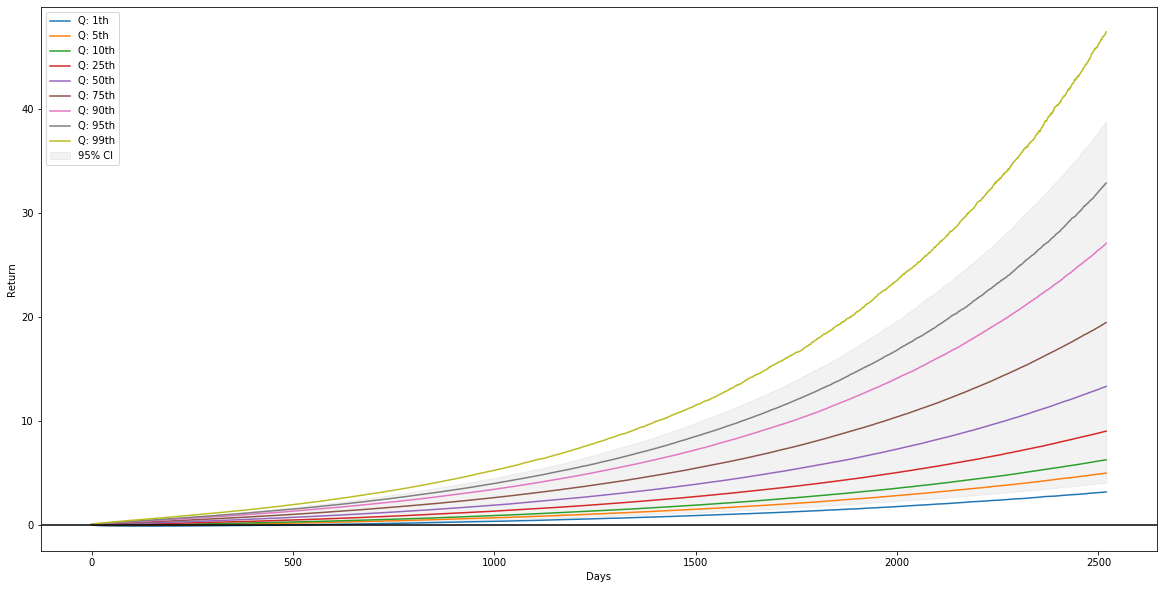

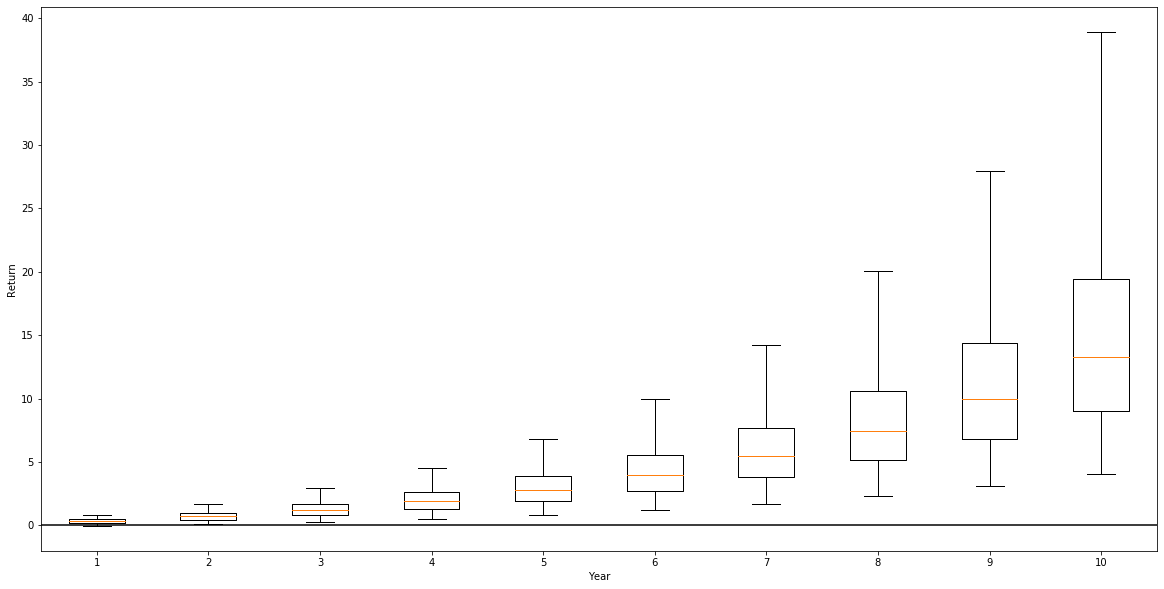

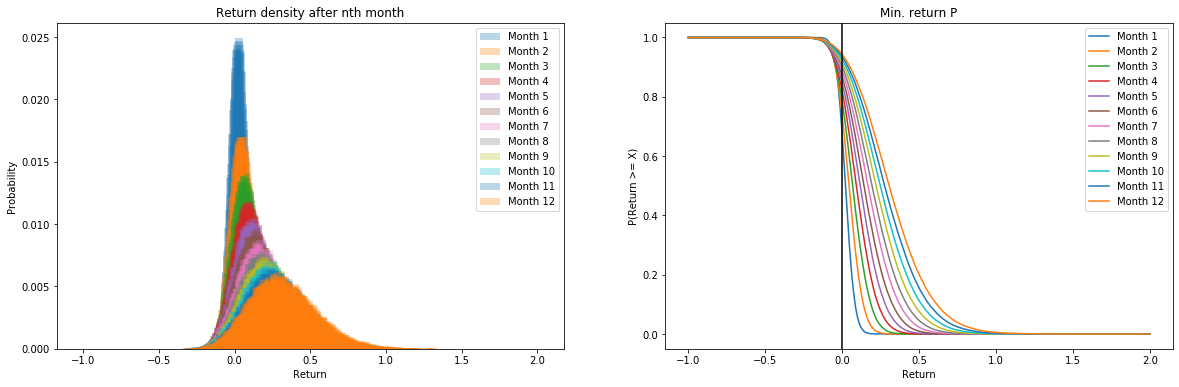

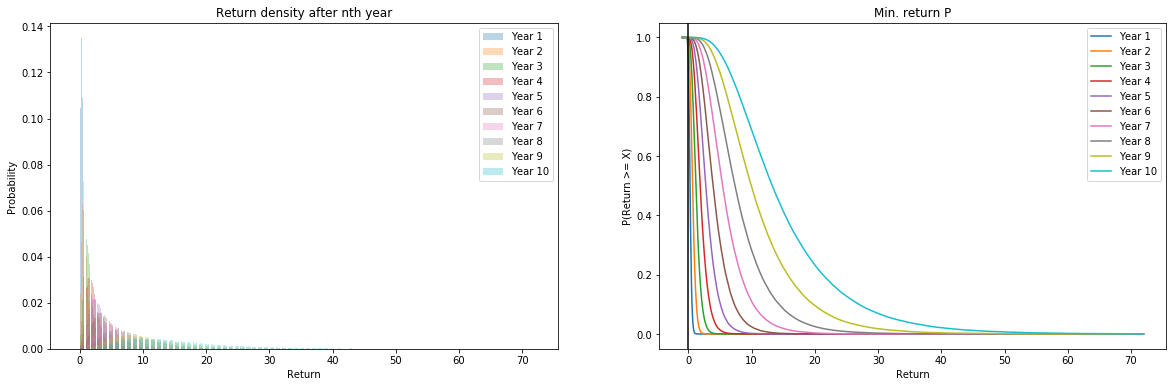

,< 0,> 0,>= 1,>= 2,>= 3,>= 4,>= 5,>= 6,>= 7,>= 8,>= 9,>= 10
Year,,,,,,,,,,,,
1,5.538,94.462,0.541,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,1.263,98.737,25.018,0.817,0.017,0.001,0.000,0.000,0.000,0.000,0.000,0.000
3,0.313,99.687,64.508,15.063,2.117,0.238,0.028,0.001,0.000,0.000,0.000,0.000
4,0.078,99.922,86.727,46.090,16.886,5.099,1.453,0.405,0.093,0.031,0.010,0.001
5,0.021,99.979,95.497,73.376,44.560,22.994,10.846,4.861,2.155,0.969,0.443,0.216
6,0.007,99.993,98.584,88.632,69.628,49.034,31.877,19.784,11.868,6.998,4.125,2.452
7,0.002,99.998,99.537,95.595,85.872,71.688,56.530,42.736,31.350,22.511,16.007,11.140
8,0.000,100.000,99.847,98.476,94.122,86.160,76.212,65.178,54.236,44.291,35.716,28.525
9,0.000,100.000,99.961,99.479,97.737,94.002,88.488,81.441,73.538,65.428,57.517,49.887


In [116]:
cum_returns = plot_traces(traces)
returns_table(cum_returns)

### MCMC Projection

In [22]:
mcmc_traces = mcmc_sample_returns(ret, 10 * 252, n_traces=100000, mc_states = 10, n_jobs=10)

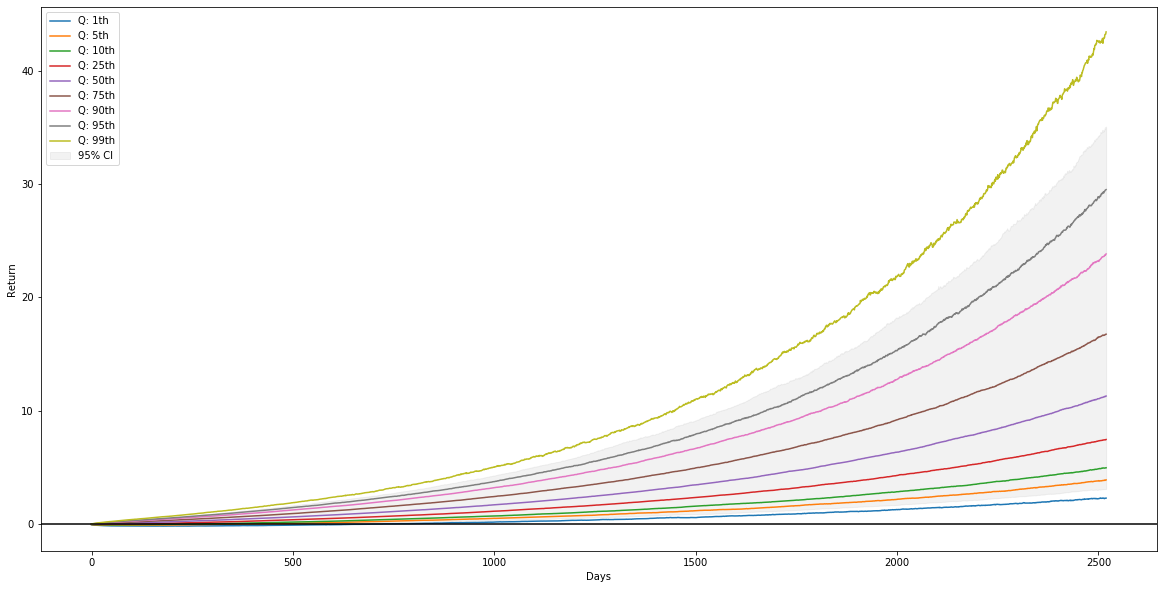

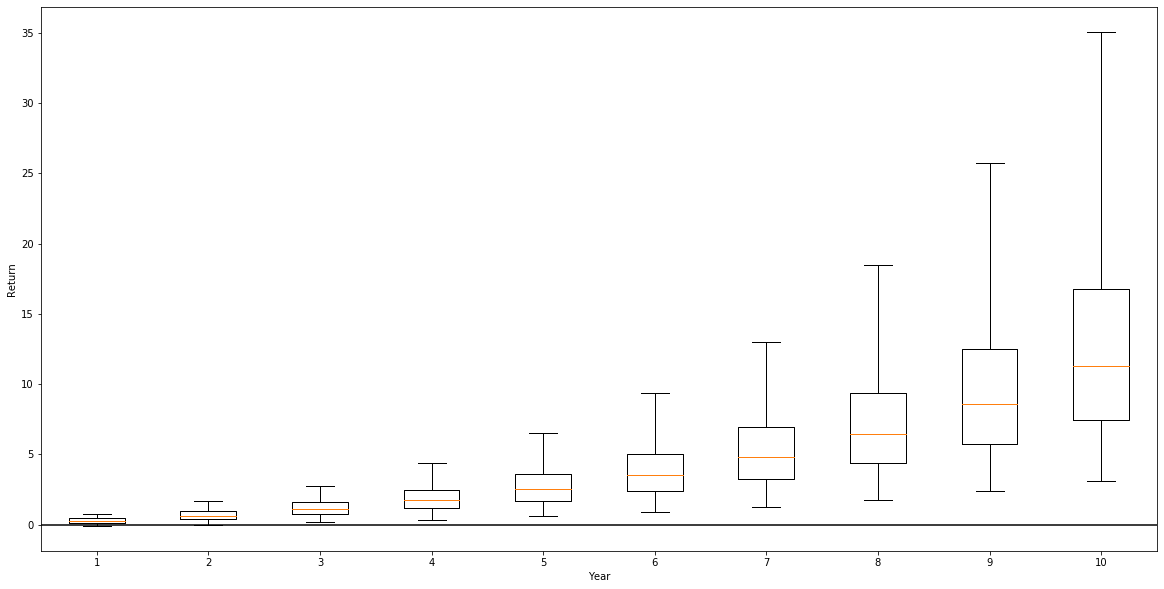

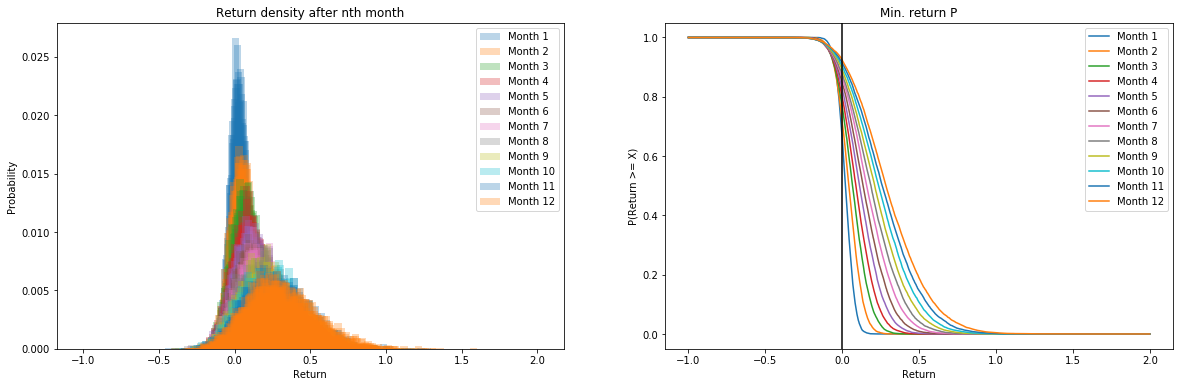

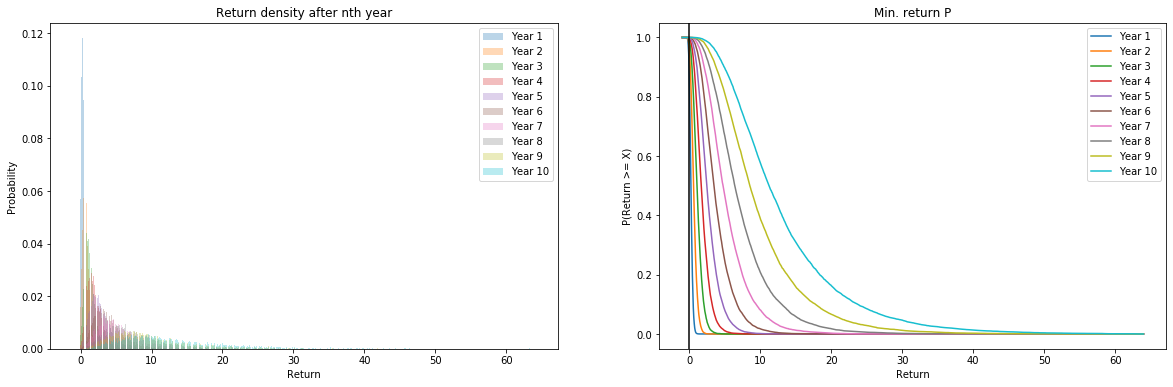

,< 0,> 0,>= 1,>= 2,>= 3,>= 4,>= 5,>= 6,>= 7,>= 8,>= 9,>= 10
Year,,,,,,,,,,,,
1,7.44,92.56,0.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2.42,97.58,22.30,0.73,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.64,99.36,58.26,12.54,1.58,0.17,0.02,0.00,0.00,0.00,0.00,0.00
4,0.22,99.78,81.54,39.51,13.74,3.95,1.15,0.34,0.13,0.03,0.01,0.00
5,0.08,99.92,92.37,65.90,37.27,18.25,8.39,3.84,1.63,0.70,0.32,0.17
6,0.00,100.00,97.01,83.18,61.42,40.80,25.23,15.33,8.79,5.10,2.90,1.80
7,0.00,100.00,98.81,91.62,79.18,62.55,47.43,34.43,24.60,16.83,11.56,8.19
8,0.00,100.00,99.57,96.36,89.33,79.45,67.38,55.42,44.39,35.05,27.64,21.15
9,0.00,100.00,99.88,98.61,94.71,88.87,81.52,72.89,63.84,55.19,46.83,39.37


In [23]:
mcmc_cum_returns = plot_traces(mcmc_traces)
returns_table(mcmc_cum_returns)